In [2]:
# imports
import pandas as pd
import geopandas as gpd
import geojson
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry
import geopy
from geopy.geocoders import Nominatim
import plotly
import plotly.express as px
import json
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [3]:
# for matplotlib figures have a better pixels to save image
plt.rcParams['figure.dpi'] = 150

In [4]:
# upload geodata
states_amazon = gpd.read_file('states_amazon_biome/states_amazon_biome.shp')

In [7]:
# feature engineering and clean up data

def clean_up(X):
    X = X.copy()
    
    # lowercase column names
    X.columns = map(str.lower, X.columns)
    
    # retrieve latitude and longitude from geometry polygon
    X['lon'] = X.centroid.x
    X['lat'] = X.centroid.y
    
    # get the month, year, and day
    X['view_date'] = pd.to_datetime(X['view_date'])
    X['day'] = pd.to_datetime(X['view_date']).dt.day
    X['month'] = pd.to_datetime(X['view_date']).dt.month
    X['year'] = pd.to_datetime(X['view_date']).dt.year
        
    # give the column proper name
    X = X.rename(columns={'areakm': 'areakm_squared'}) 
    
    # add states names # ['Para', 'Mato Grosso', 'Rondonia', 'Amazonias', 'Acre', 'Roraima', 'Amapa', 'Tocantins']
    X['states'] = X['uf'].replace({'PA': 'Para', 'MT': 'Mato Grosso', 'RO': 'Rondonia', 'AM': 'Amazonas',
                                   'MA': 'Maranhao', 'AC': 'Acre', 'RR': 'Roraima',
                                  'AP': 'Amapa', 'TO': 'Tocantins'})
    # remove multipolygons
    X = X.drop(columns=['geometry'])
    
    # remove outliers (values that are more than 3 standard deviations from the mean)
    z_scores = zscore(X['areakm_squared'])
    z_scores_abs = np.abs(z_scores)
    z_scores_abs
    z_scores_filtered = z_scores < 3
    X = X[z_scores_filtered]
    
    # get rid of zeros
    cols_with_zeros = ['scene_id', 'dsfnv', 'areakm_squared']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    return X

In [13]:
# sample exploration
sample_df = pd.read_csv('sample.csv')
sample_df.head(3)

gid  origin_id  uf  pathrow     mainclass class_name   dsfnv  julday  \
0  539272   993253.0  PA    22564  DESMATAMENTO      d2011     NaN   201.0   
1  314421   618723.0  MA    22262  DESMATAMENTO      d2009  2003.0   222.0   
2  163715   446097.0  RO    23267  DESMATAMENTO      d2016     NaN   200.0   

             view_date     ano  areakm_squared  scene_id           publish_ye  \
0  2011-07-20 00:00:00  2011.0        0.240524    1308.0  2011-01-01 00:00:00   
1  2009-08-10 00:00:00  2009.0        0.088040     807.0  2009-01-01 00:00:00   
2  2016-07-18 00:00:00  2016.0        0.064452  100246.0  2016-01-01 00:00:00   

         lon        lat  day  month  year    states  
0 -52.081068  -6.160166   20      7  2011      Para  
1 -46.274499  -3.253265   10      8  2009  Maranhao  
2 -64.309147 -10.407470   18      7  2016  Rondonia

In [14]:
# profile report on sample
profile = ProfileReport(sample_df, minimal=True).to_notebook_iframe()

profile

In [16]:
# data exploration sample set
sample['areakm_squared'].describe()

count    4.709200e+04
mean     1.296311e-01
std      1.517382e-01
min      1.000000e-15
25%      6.494035e-02
50%      8.890871e-02
75%      1.438794e-01
max      1.439702e+00
Name: areakm_squared, dtype: float64

In [28]:
# exploration of states data set
states_amazon['geometry']

0    MULTIPOLYGON (((-66.62648 -9.90087, -66.62657 ...
1    POLYGON ((-54.00084 2.23030, -54.00077 2.23032...
2    POLYGON ((-73.80065 -7.11215, -73.80098 -7.111...
3    MULTIPOLYGON (((-43.99733 -2.40111, -43.99847 ...
4    MULTIPOLYGON (((-50.25039 -9.83957, -50.26614 ...
5    MULTIPOLYGON (((-46.06634 -1.10459, -46.06909 ...
6    POLYGON ((-59.96165 -12.05642, -59.96981 -12.0...
7    POLYGON ((-60.17060 5.22688, -60.17054 5.22688...
8    MULTIPOLYGON (((-47.87031 -5.28111, -47.87042 ...
Name: geometry, dtype: geometry

In [29]:
# coordinate referene system WGS84 Latitude/Longitude: "EPSG:4326"

def coord_ref(df):
    # copy df
    X = df.copy()
    
    # convert coordinates
    X = X.to_crs("EPSG:4326")
    
    return X

In [30]:

df_samps = [states_amazon]
for df in df_samps:
    coord_ref(df)


In [31]:
# Working with polygons

# convert to json and make it str
states = json.dumps(shapely.geometry.mapping(states_amazon))

# check type
# type(states) # str

# convert str to geojson
states_geojson = geojson.loads(states)

# states_geojson['type'] # 'FeatureCollection'

# print feature keys
print(states_geojson['features'][0].keys())

# print length
print(len(states_geojson['features']))

# print properties
print(states_geojson['features'][0]['properties'])

# set the locations id matching to polygon id length
states_names_locations_id = [k for k in range(0,9)]

print(states_names_locations_id)

dict_keys(['type', 'bbox', 'id', 'geometry', 'properties'])
9
{'CD_GEOCUF': '12', 'NM_ESTADO': 'ACRE', 'NM_REGIAO': 'NORTE'}
[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [38]:
######################################################
################ MODELING SECTION ####################
######################################################

In [ ]:
########### SAME WORK ON SAMPLE (FOR HEROKU AND GITHUB)

In [39]:
# Import everything for models
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

# choose metrics MAE (because leaving some outliers)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [121]:
# train/val/test split timebased (Sample of the population)
train = sample_df[sample_df['year'] <= 2015]
val = sample_df[sample_df['year'] == 2016]
test = sample_df[sample_df['year'] >= 2017]

train = train.round({"lat":4, "lon":4})
val = val.round({'lat':4, 'lon':4})
test = test.round({'lat':4, 'lon':4})

train.shape, val.shape, test.shape

((35123, 19), (3808, 19), (8174, 19))

In [122]:
# split on matrix features and target vector
X_train = train[features]
y_train_1 = train[target1]
y_train_2 = train[target2]
X_val = val[features]
y_val_1 = val[target1]
y_val_2 = val[target2]
X_test = test[features]
y_test_1 = test[target1]
y_test_2 = test[target2]

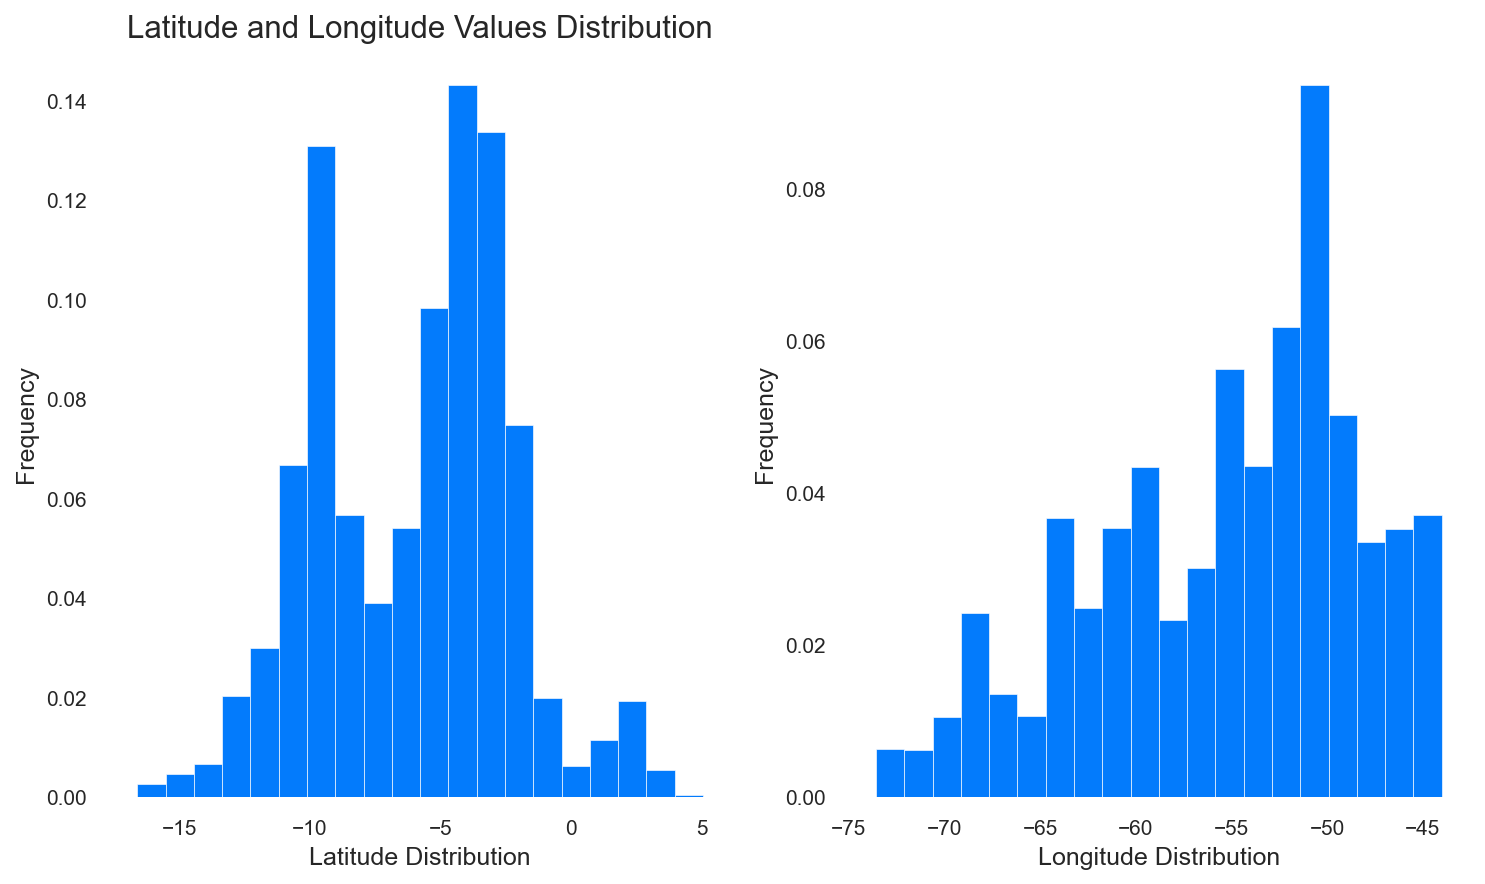

In [123]:
# distribution of sample data
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10,6))

axs[0].hist(y_train_1, bins=20, density=True, color='#037bfc')
axs[1].hist(y_train_2, bins=20, density=True, color='#037bfc')
axs[0].set_title('Latitude and Longitude Values Distribution', fontsize=15)
axs[0].set_xlabel('Latitude Distribution', fontsize=12)
axs[0].set_ylabel('Frequency', fontsize=12)
axs[1].set_xlabel('Longitude Distribution', fontsize=12)
axs[1].set_ylabel('Frequency', fontsize=12);

In [124]:
# Ridge Regression trained on sample
ridge_model = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    SelectKBest(f_regression, k='all'), 
    Ridge(alpha=1)
)

ridge_model.fit(X_train, y_train_1)
y_val_pred_1 = ridge_model.predict(X_val)
ridge_model.fit(X_train, y_train_2)
y_val_pred_2 = ridge_model.predict(X_val)

print(f'Ridge model validation MAE: {mean_absolute_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'Ridge model validation MAE: {mean_absolute_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'Ridge model Validation RMSE loss: {mean_squared_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'Ridge model Validation RMSE loss: {mean_squared_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'Ridge model Validation R^2 coefficient: {r2_score(y_val_1, y_val_pred_1):.4f} lat')
print(f'Ridge model Validation R^2 coefficient: {r2_score(y_val_2, y_val_pred_2):.4f} lon')

Ridge model validation MAE: 1.3317 lat
Ridge model validation MAE: 1.8570 lon
Ridge model Validation RMSE loss: 2.8493 lat
Ridge model Validation RMSE loss: 5.5458 lon
Ridge model Validation R^2 coefficient: 0.7920 lat
Ridge model Validation R^2 coefficient: 0.8772 lon


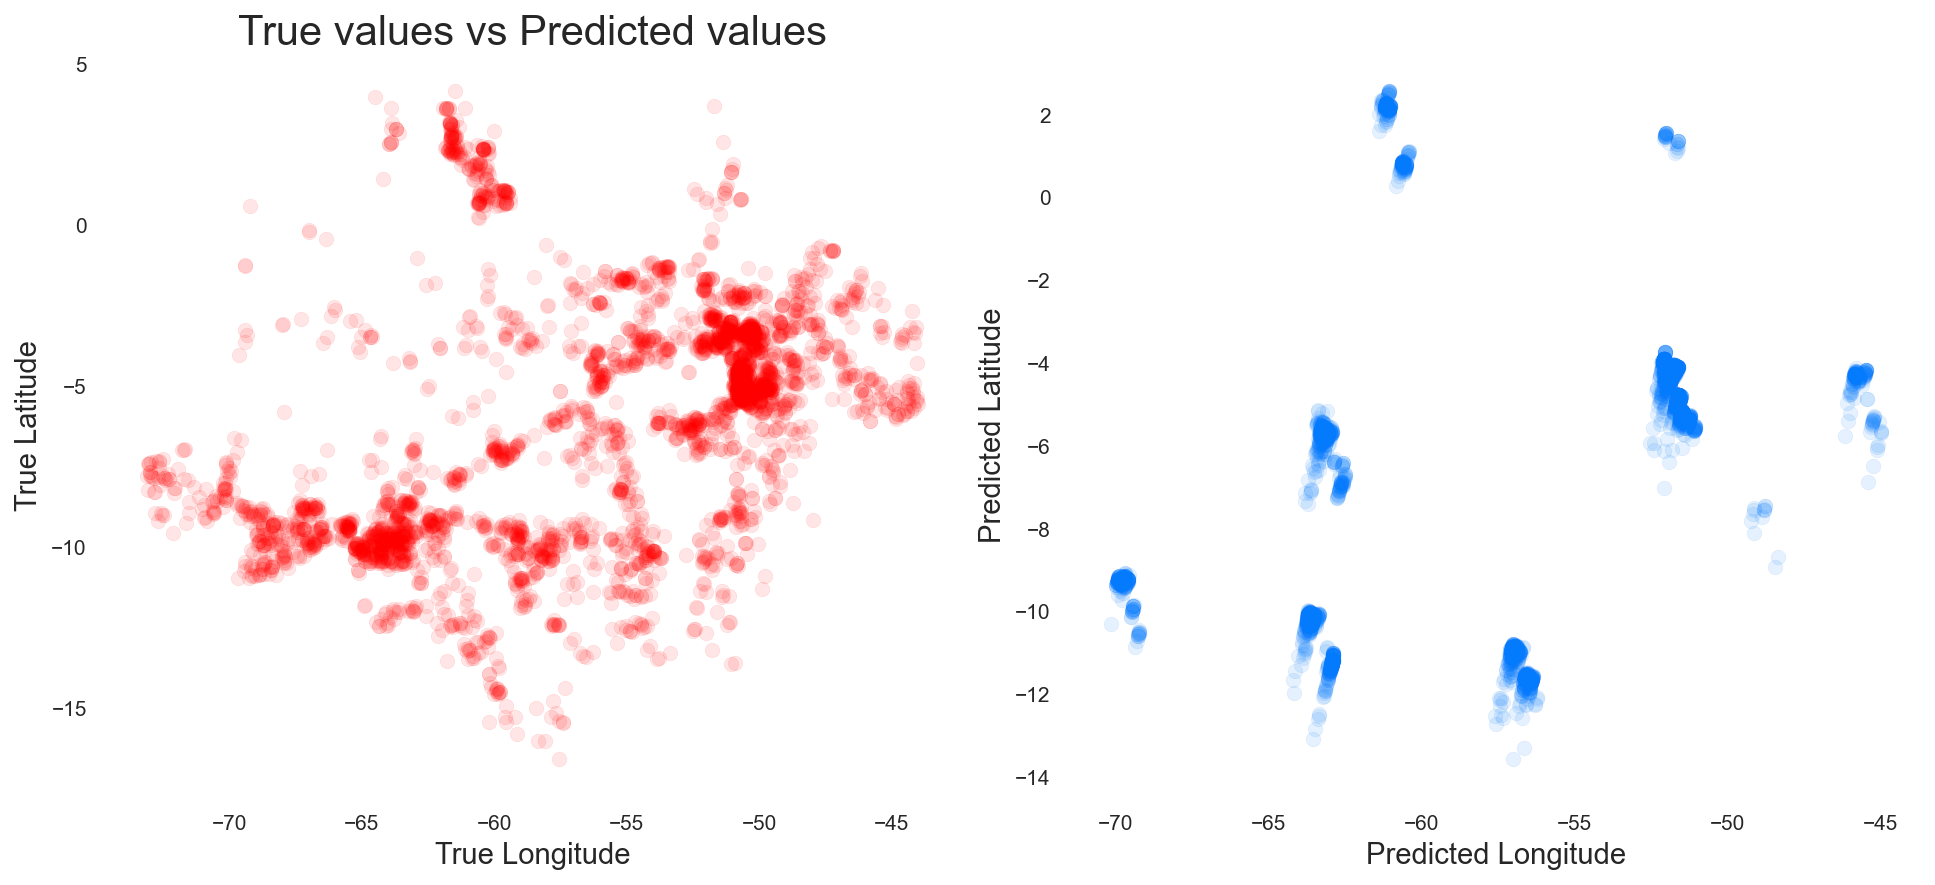

In [125]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(13,6))

axs[0].scatter(x=y_val_2, y=y_val_1, c='#FF0000', alpha=0.1)
axs[1].scatter(x=y_val_pred_2, y=y_val_pred_1, c='#037bfc', alpha=0.1)
axs[0].set_title('True values vs Predicted values', fontsize=20)
axs[0].set_xlabel('True Longitude', fontsize=14)
axs[0].set_ylabel('True Latitude', fontsize=14)
axs[1].set_xlabel('Predicted Longitude', fontsize=14)
axs[1].set_ylabel('Predicted Latitude', fontsize=14);

In [126]:
# Desicion Tree Model
# Decision Tree Regressor trained on population
dt1 = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeRegressor(random_state=42)
)
dt2 = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeRegressor(random_state=42)
)

dt1.fit(X_train, y_train_1)
y_val_pred_1 = dt1.predict(X_val)
dt2.fit(X_train, y_train_2)
y_val_pred_2 = dt2.predict(X_val)

print(f'Desicion Tree validation MAE: {mean_absolute_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'Desicion Tree validation MAE: {mean_absolute_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'Desicion Tree Validation RMSE loss: {mean_squared_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'Desicion Tree Validation RMSE loss: {mean_squared_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'Desicion Tree Validation R^2 coefficient: {r2_score(y_val_1, y_val_pred_1):.4f} lat')
print(f'Desicion Tree Validation R^2 coefficient: {r2_score(y_val_2, y_val_pred_2):.4f} lon')

Desicion Tree validation MAE: 1.9517 lat
Desicion Tree validation MAE: 3.2465 lon
Desicion Tree Validation RMSE loss: 6.2259 lat
Desicion Tree Validation RMSE loss: 16.2825 lon
Desicion Tree Validation R^2 coefficient: 0.5455 lat
Desicion Tree Validation R^2 coefficient: 0.6394 lon


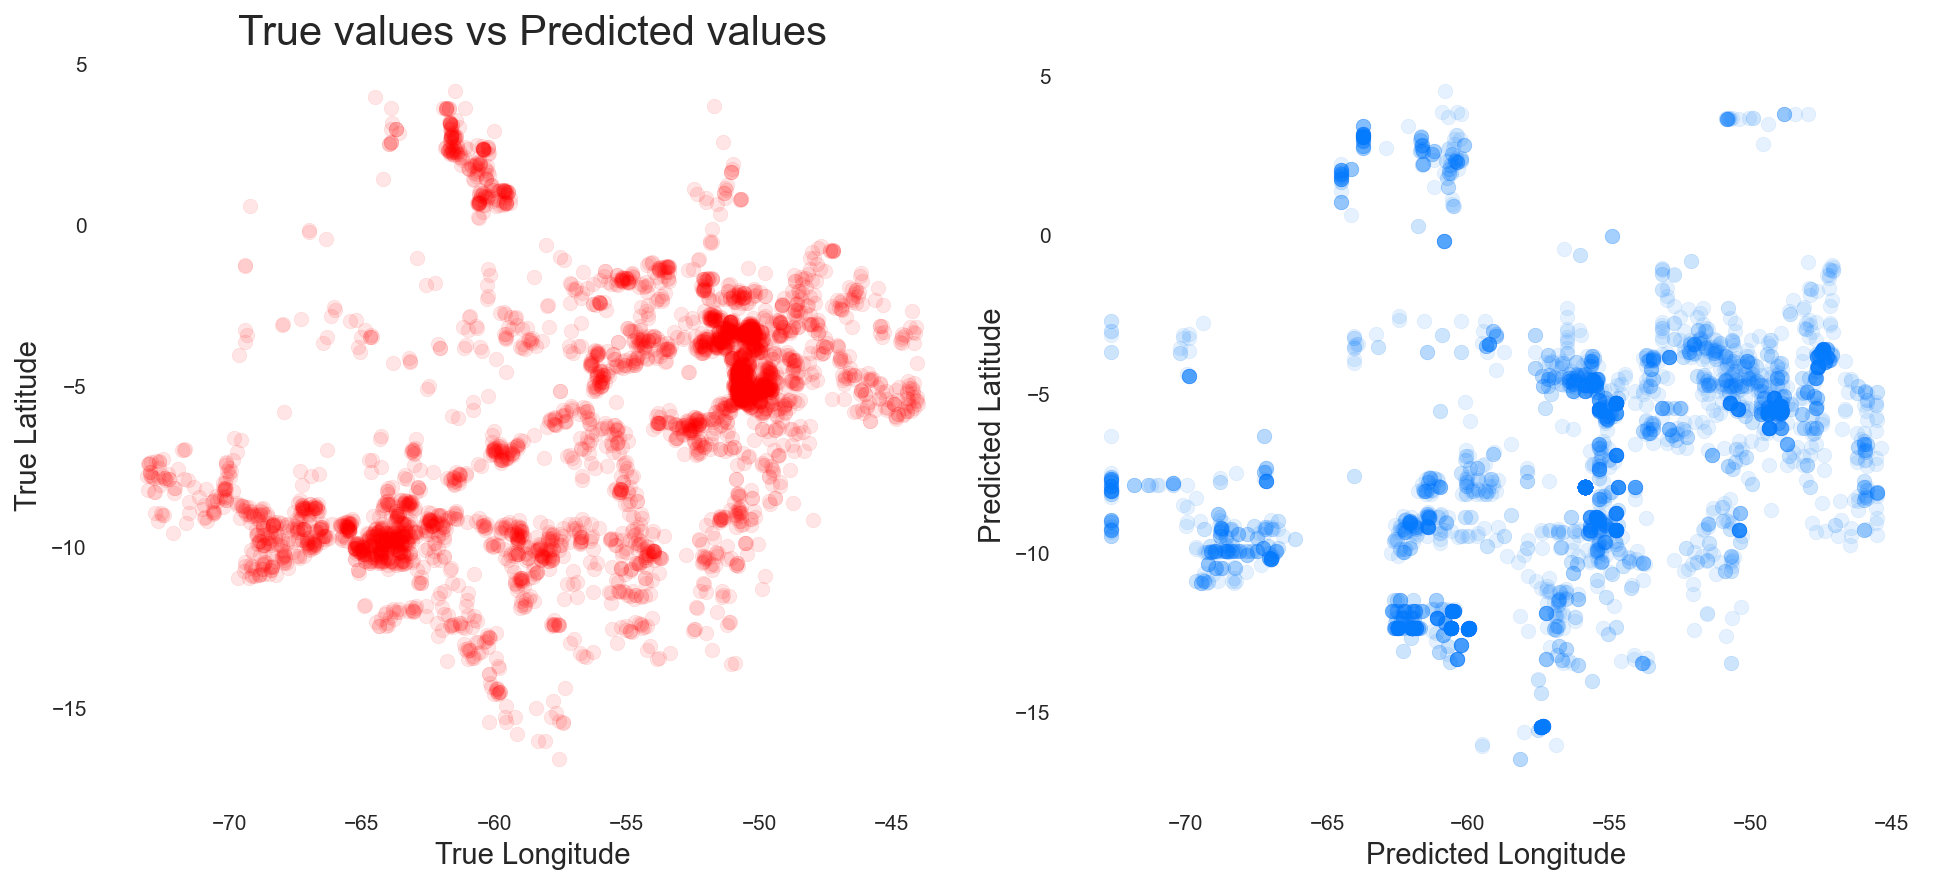

In [127]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(13,6))

axs[0].scatter(x=y_val_2, y=y_val_1, c='red', alpha=0.1)
axs[1].scatter(x=y_val_pred_2, y=y_val_pred_1, c='#037bfc', alpha=0.1)
axs[0].set_title('True values vs Predicted values', fontsize=20)
axs[0].set_xlabel('True Longitude', fontsize=14)
axs[0].set_ylabel('True Latitude', fontsize=14)
axs[1].set_xlabel('Predicted Longitude', fontsize=14)
axs[1].set_ylabel('Predicted Latitude', fontsize=14);

In [128]:
# Random Forest model on Sample
# Random forest
rf1 = make_pipeline( 
    ce.TargetEncoder(min_samples_leaf=54),
#     ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestRegressor(n_estimators=108, random_state=42, n_jobs=-1, max_features=0.31276908252447455)
)

rf2 = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=329),
#     ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=186, random_state=42, n_jobs=-1, max_features=0.6404643986998269)
)
# max_depth (usually high, can try decreasing)
# n_estimators (too low underfits, too high wastes time)
# min_samples_leaf (increase if overfitting)
# max_features (decrease for more diverse trees)

rf1.fit(X_train, y_train_1)
y_val_pred_1 = rf1.predict(X_val)
rf2.fit(X_train, y_train_2)
y_val_pred_2 = rf2.predict(X_val)
print(f'Random Forest Validation MAE: {mean_absolute_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'Random Forest Validation MAE: {mean_absolute_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'Random Forest Validation RMSE loss: {mean_squared_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'Random Forest Validation RMSE loss: {mean_squared_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'Random Forest Validation R^2 coefficient: {r2_score(y_val_1, y_val_pred_1):.4f} lat')
print(f'Random Forest Validation R^2 coefficient: {r2_score(y_val_2, y_val_pred_2):.4f} lon')

Random Forest Validation MAE: 1.5203 lat
Random Forest Validation MAE: 2.5654 lon
Random Forest Validation RMSE loss: 3.7385 lat
Random Forest Validation RMSE loss: 9.1794 lon
Random Forest Validation R^2 coefficient: 0.7271 lat
Random Forest Validation R^2 coefficient: 0.7967 lon


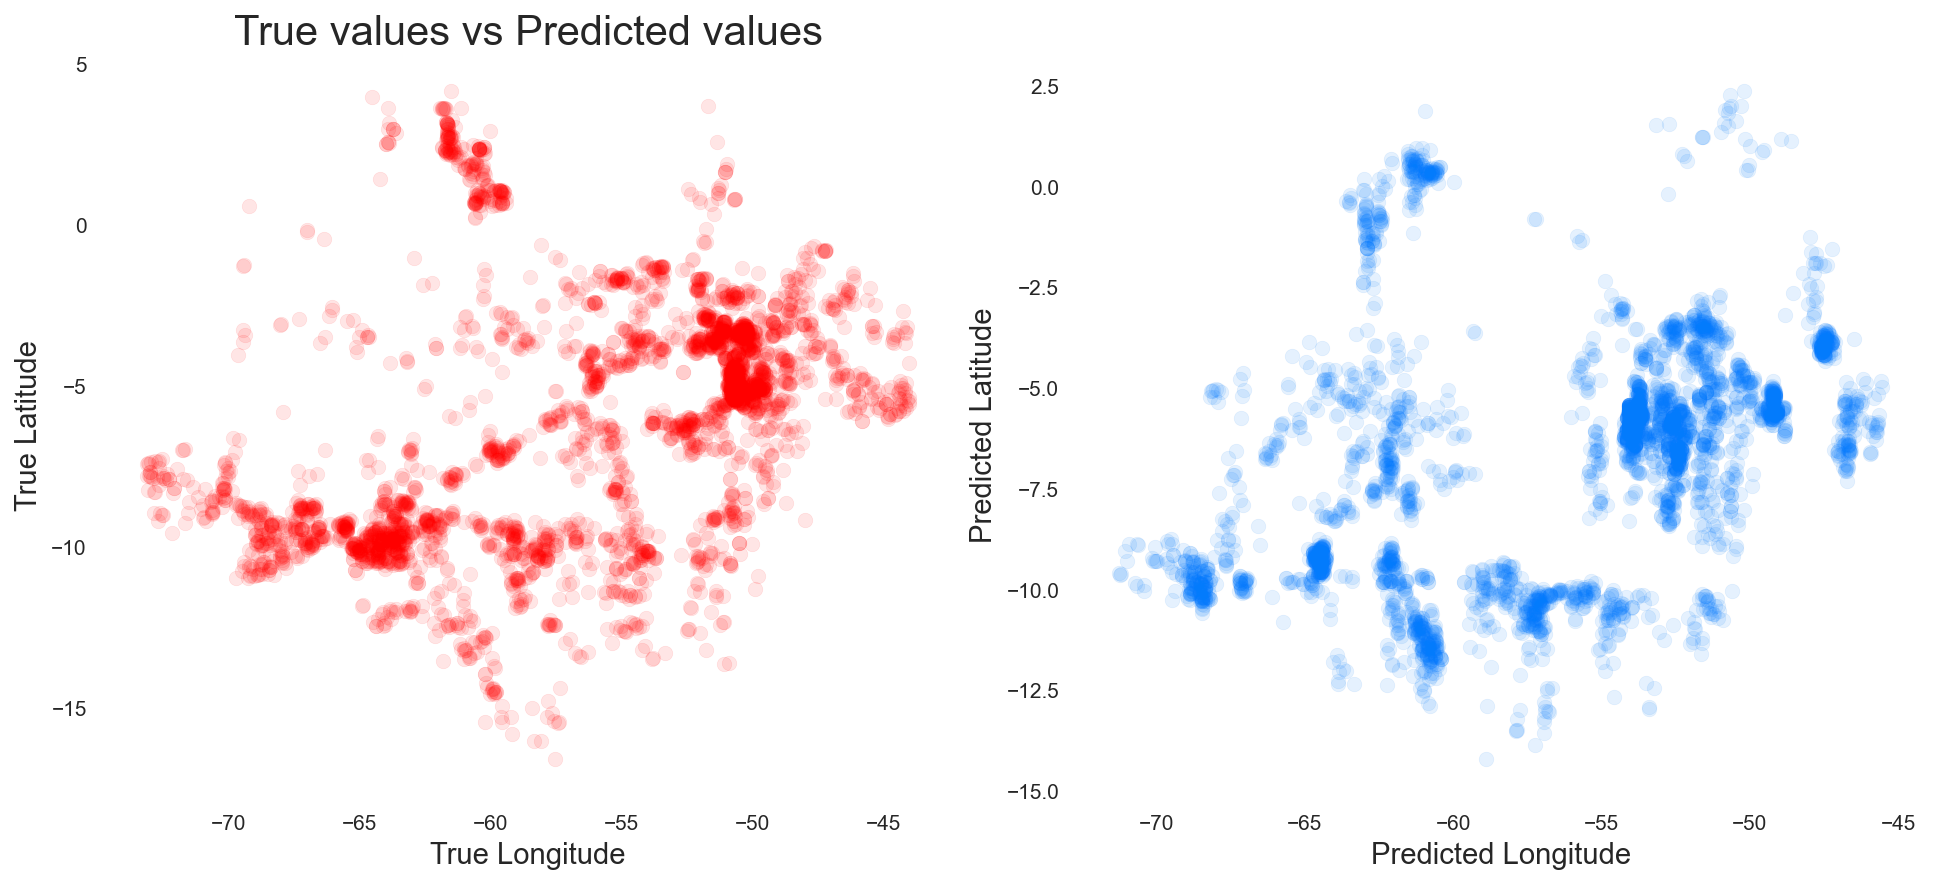

In [129]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(13,6))

axs[0].scatter(x=y_val_2, y=y_val_1, c='red', alpha=0.1)
axs[1].scatter(x=y_val_pred_2, y=y_val_pred_1, c='#037bfc', alpha=0.1)
axs[0].set_title('True values vs Predicted values', fontsize=20)
axs[0].set_xlabel('True Longitude', fontsize=14)
axs[0].set_ylabel('True Latitude', fontsize=14)
axs[1].set_xlabel('Predicted Longitude', fontsize=14)
axs[1].set_ylabel('Predicted Latitude', fontsize=14);

In [130]:
# XGBoost on Sample

xgb1 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=50)
)
xgb2 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=50)
)
xgb1.fit(X_train, y_train_1)
y_val_pred_1 = xgb1.predict(X_val)
xgb2.fit(X_train, y_train_2)
y_val_pred_2 = xgb2.predict(X_val)
print(f'XGBoost Validation MAE: {mean_absolute_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'XGBoost Validation MAE: {mean_absolute_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'XGBoost Validation RMSE loss: {mean_squared_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'XGBoost Validation RMSE loss: {mean_squared_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'XGBoost Validation R^2 coefficient: {r2_score(y_val_1, y_val_pred_1):.4f} lat')
print(f'XGBoost Validation R^2 coefficient: {r2_score(y_val_2, y_val_pred_2):.4f} lon')

XGBoost Validation MAE: 1.7320 lat
XGBoost Validation MAE: 3.0866 lon
XGBoost Validation RMSE loss: 4.6898 lat
XGBoost Validation RMSE loss: 13.8507 lon
XGBoost Validation R^2 coefficient: 0.6576 lat
XGBoost Validation R^2 coefficient: 0.6933 lon


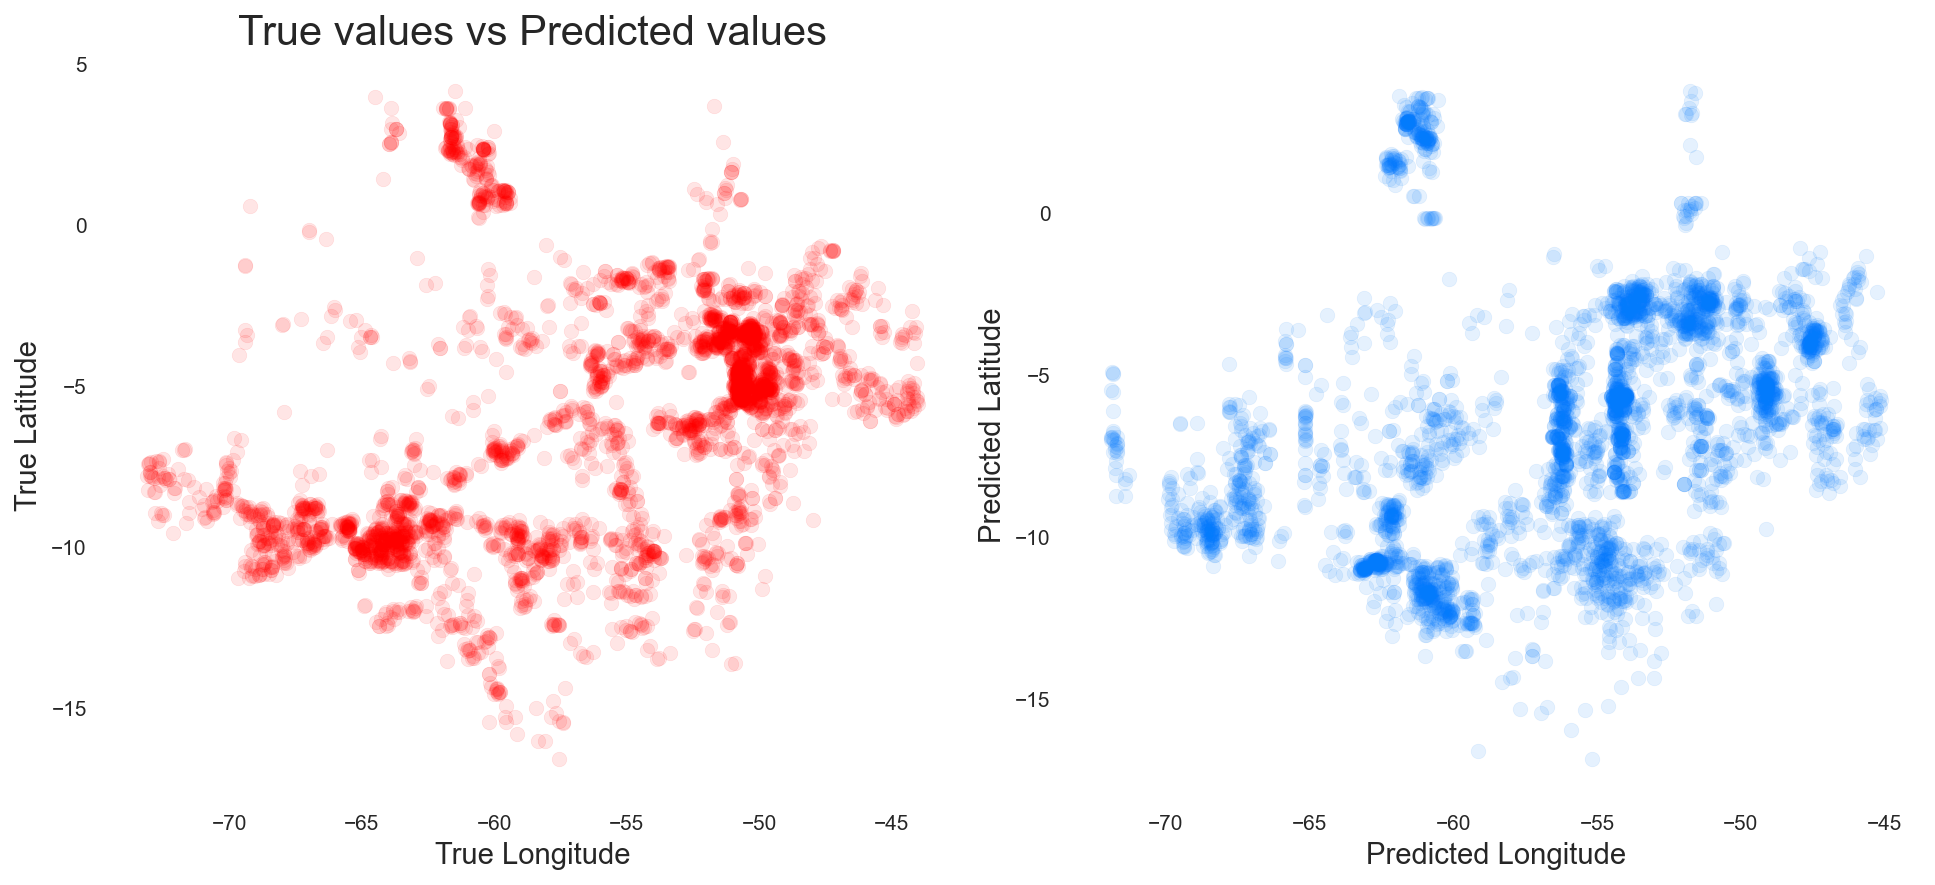

In [131]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(13,6))

axs[0].scatter(x=y_val_2, y=y_val_1, c='red', alpha=0.1)
axs[1].scatter(x=y_val_pred_2, y=y_val_pred_1, c='#037bfc', alpha=0.1)
axs[0].set_title('True values vs Predicted values', fontsize=20)
axs[0].set_xlabel('True Longitude', fontsize=14)
axs[0].set_ylabel('True Latitude', fontsize=14)
axs[1].set_xlabel('Predicted Longitude', fontsize=14)
axs[1].set_ylabel('Predicted Latitude', fontsize=14);

In [132]:
# apply Random Forest for test sample
y_pred_1 = rf1.predict(X_test)
y_pred_2 = rf2.predict(X_test)

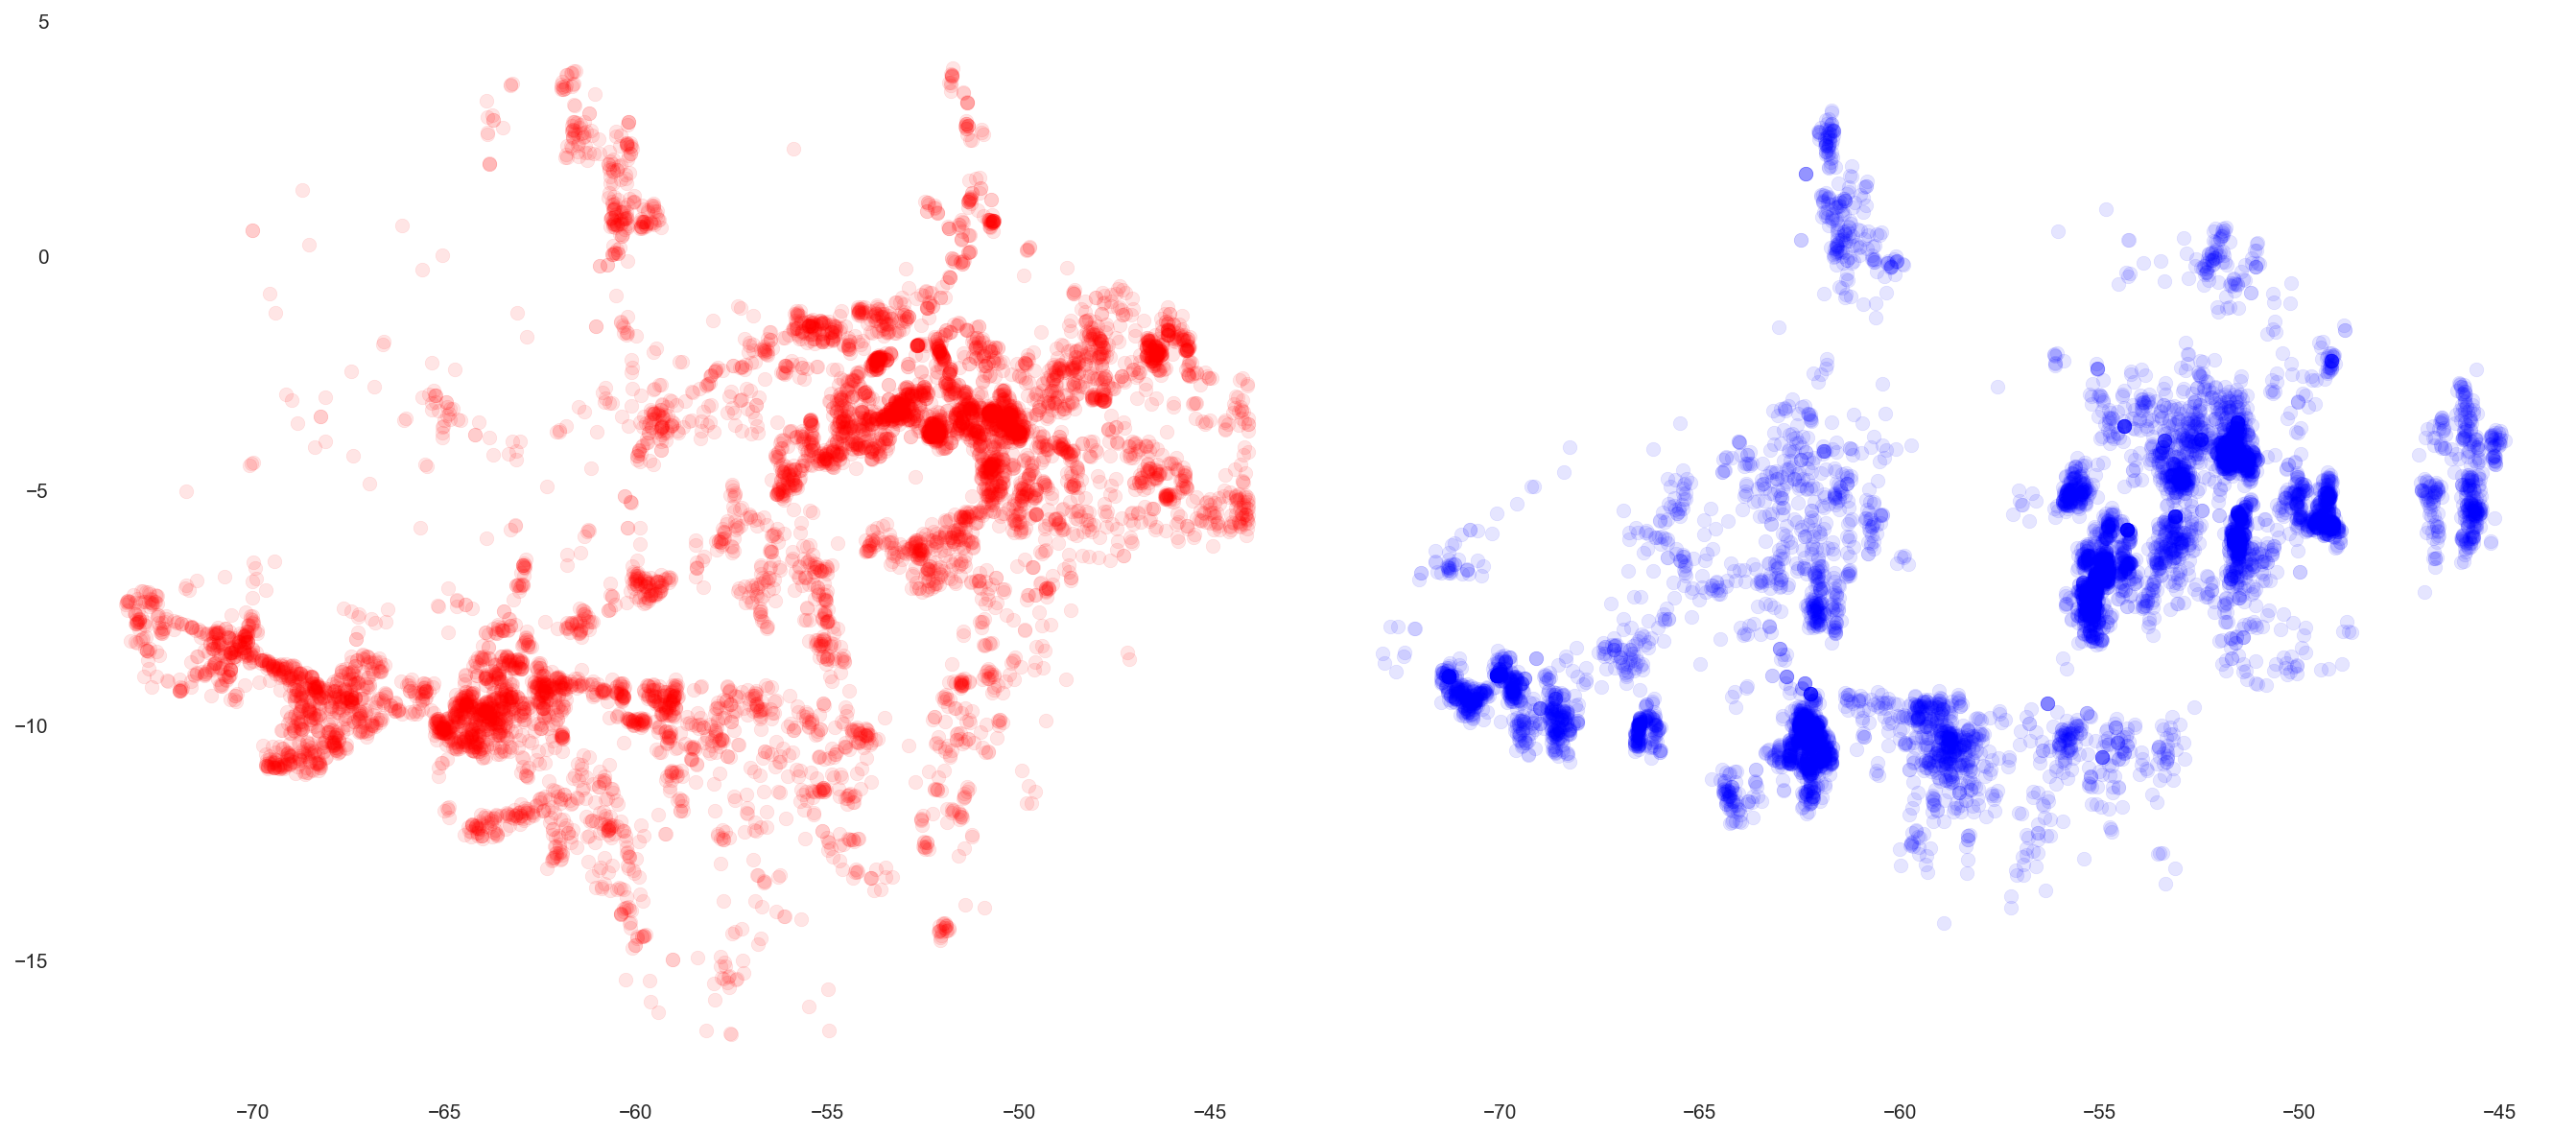

In [134]:
# visualize true vs predicted values on test sample
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(18,8))

axs[0].scatter(x=y_test_2, y=y_test_1, c='red', alpha=0.1)
axs[1].scatter(x=y_pred_2, y=y_pred_1, c='blue', alpha=0.1);

In [135]:
# XGBOOST predict on test sample
y_pred_1 = xgb1.predict(X_test)
y_pred_2 = xgb2.predict(X_test)

In [136]:
print(f'XGBoost MAE: {mean_absolute_error(y_test_1, y_pred_1):.4f} lat')
print(f'XGBoost MAE: {mean_absolute_error(y_test_2, y_pred_2):.4f} lon')
print(f'XGBoost RMSE loss: {mean_squared_error(y_test_1, y_pred_1):.4f} lat')
print(f'XGBoost RMSE loss: {mean_squared_error(y_test_2, y_pred_2):.4f} lon')
print(f'XGBoost R^2 coefficient: {r2_score(y_test_1, y_pred_1):.4f} lat')
print(f'XGBoost R^2 coefficient: {r2_score(y_test_2, y_pred_2):.4f} lon')

XGBoost MAE: 1.8635 lat
XGBoost MAE: 2.5048 lon
XGBoost RMSE loss: 5.3698 lat
XGBoost RMSE loss: 10.3433 lon
XGBoost R^2 coefficient: 0.6126 lat
XGBoost R^2 coefficient: 0.7943 lon


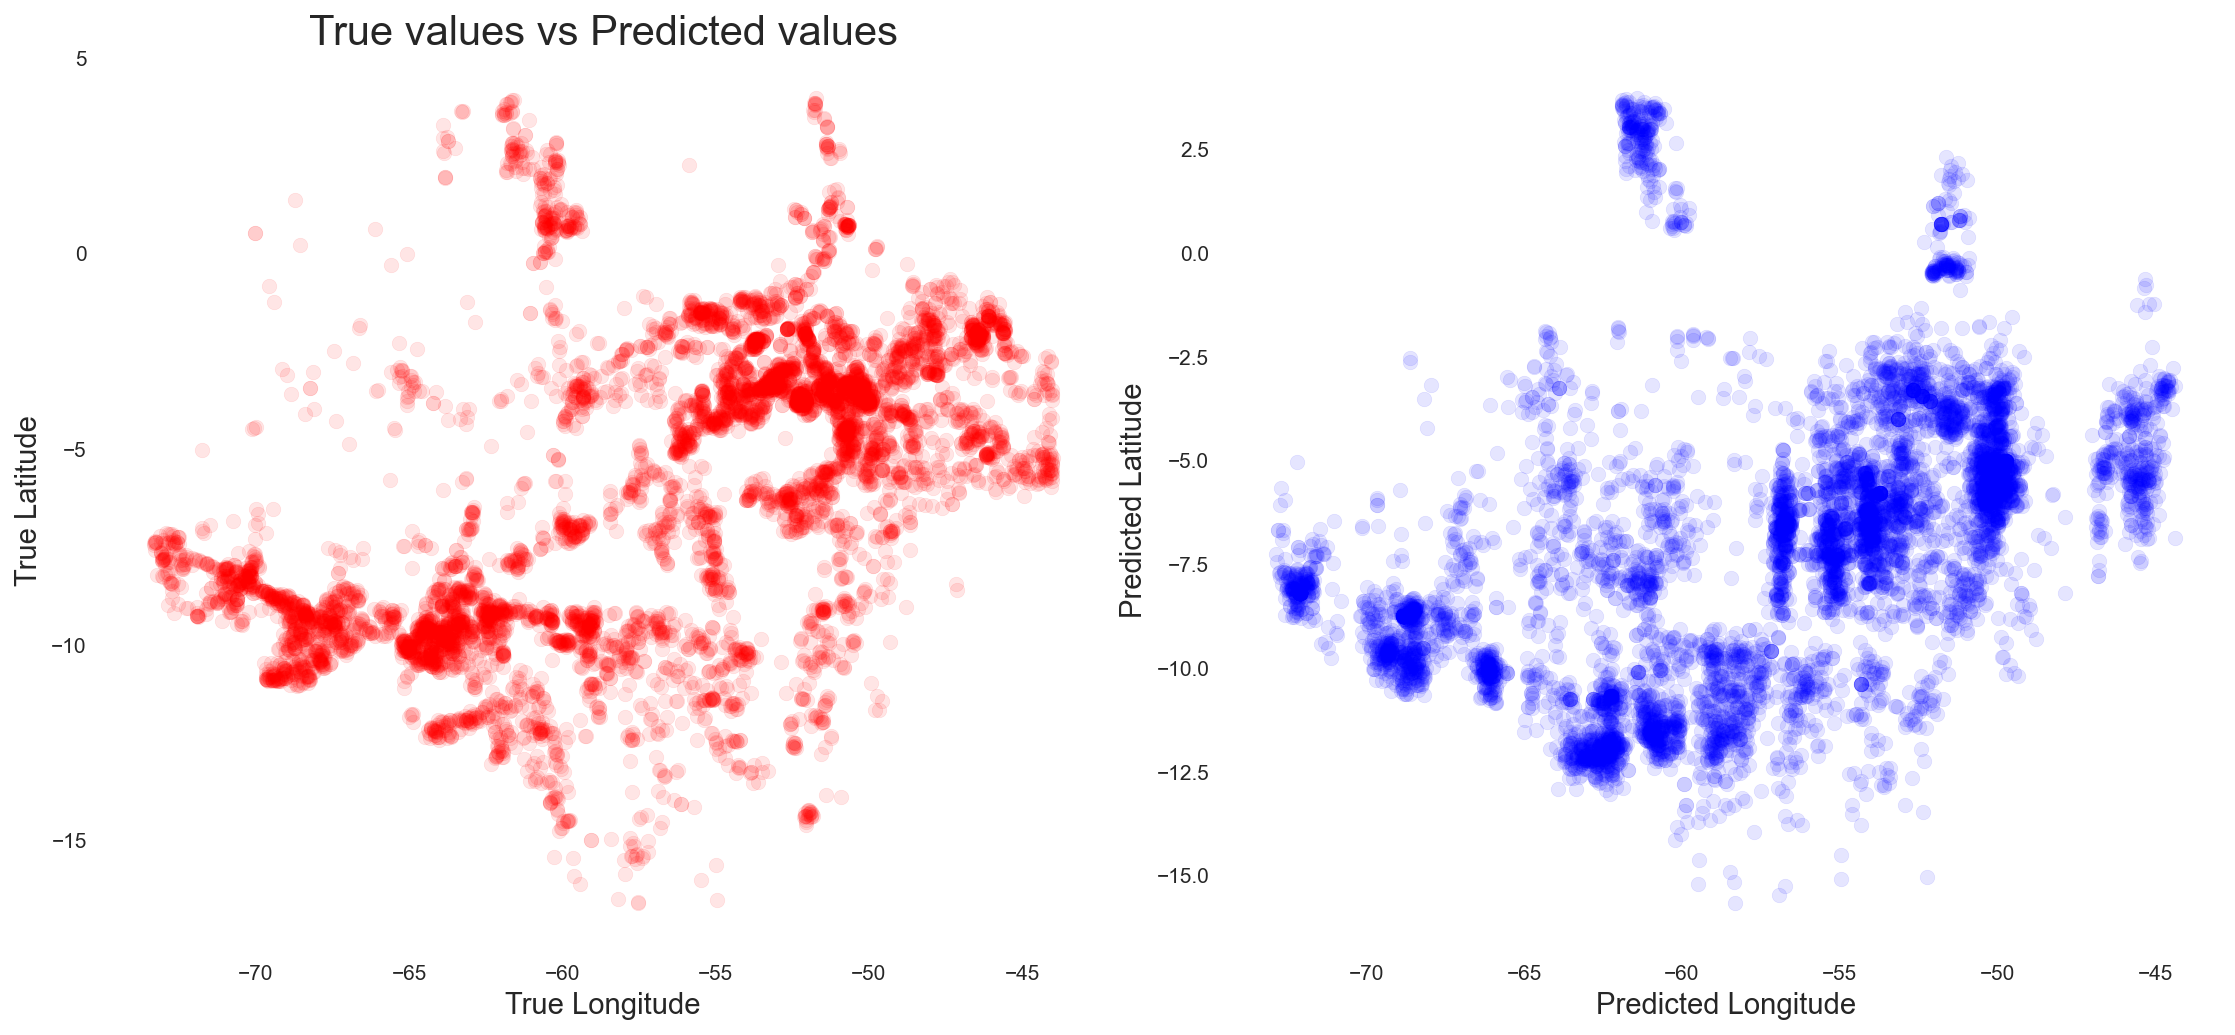

In [137]:
# visualize true vs predicted values on test sample
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(15,7))

axs[0].scatter(x=y_test_2, y=y_test_1, c='red', alpha=0.1)
axs[1].scatter(x=y_pred_2, y=y_pred_1, c='blue', alpha=0.1)
axs[0].set_title('True values vs Predicted values', fontsize=20)
axs[0].set_xlabel('True Longitude', fontsize=14)
axs[0].set_ylabel('True Latitude', fontsize=14)
axs[1].set_xlabel('Predicted Longitude', fontsize=14)
axs[1].set_ylabel('Predicted Latitude', fontsize=14);

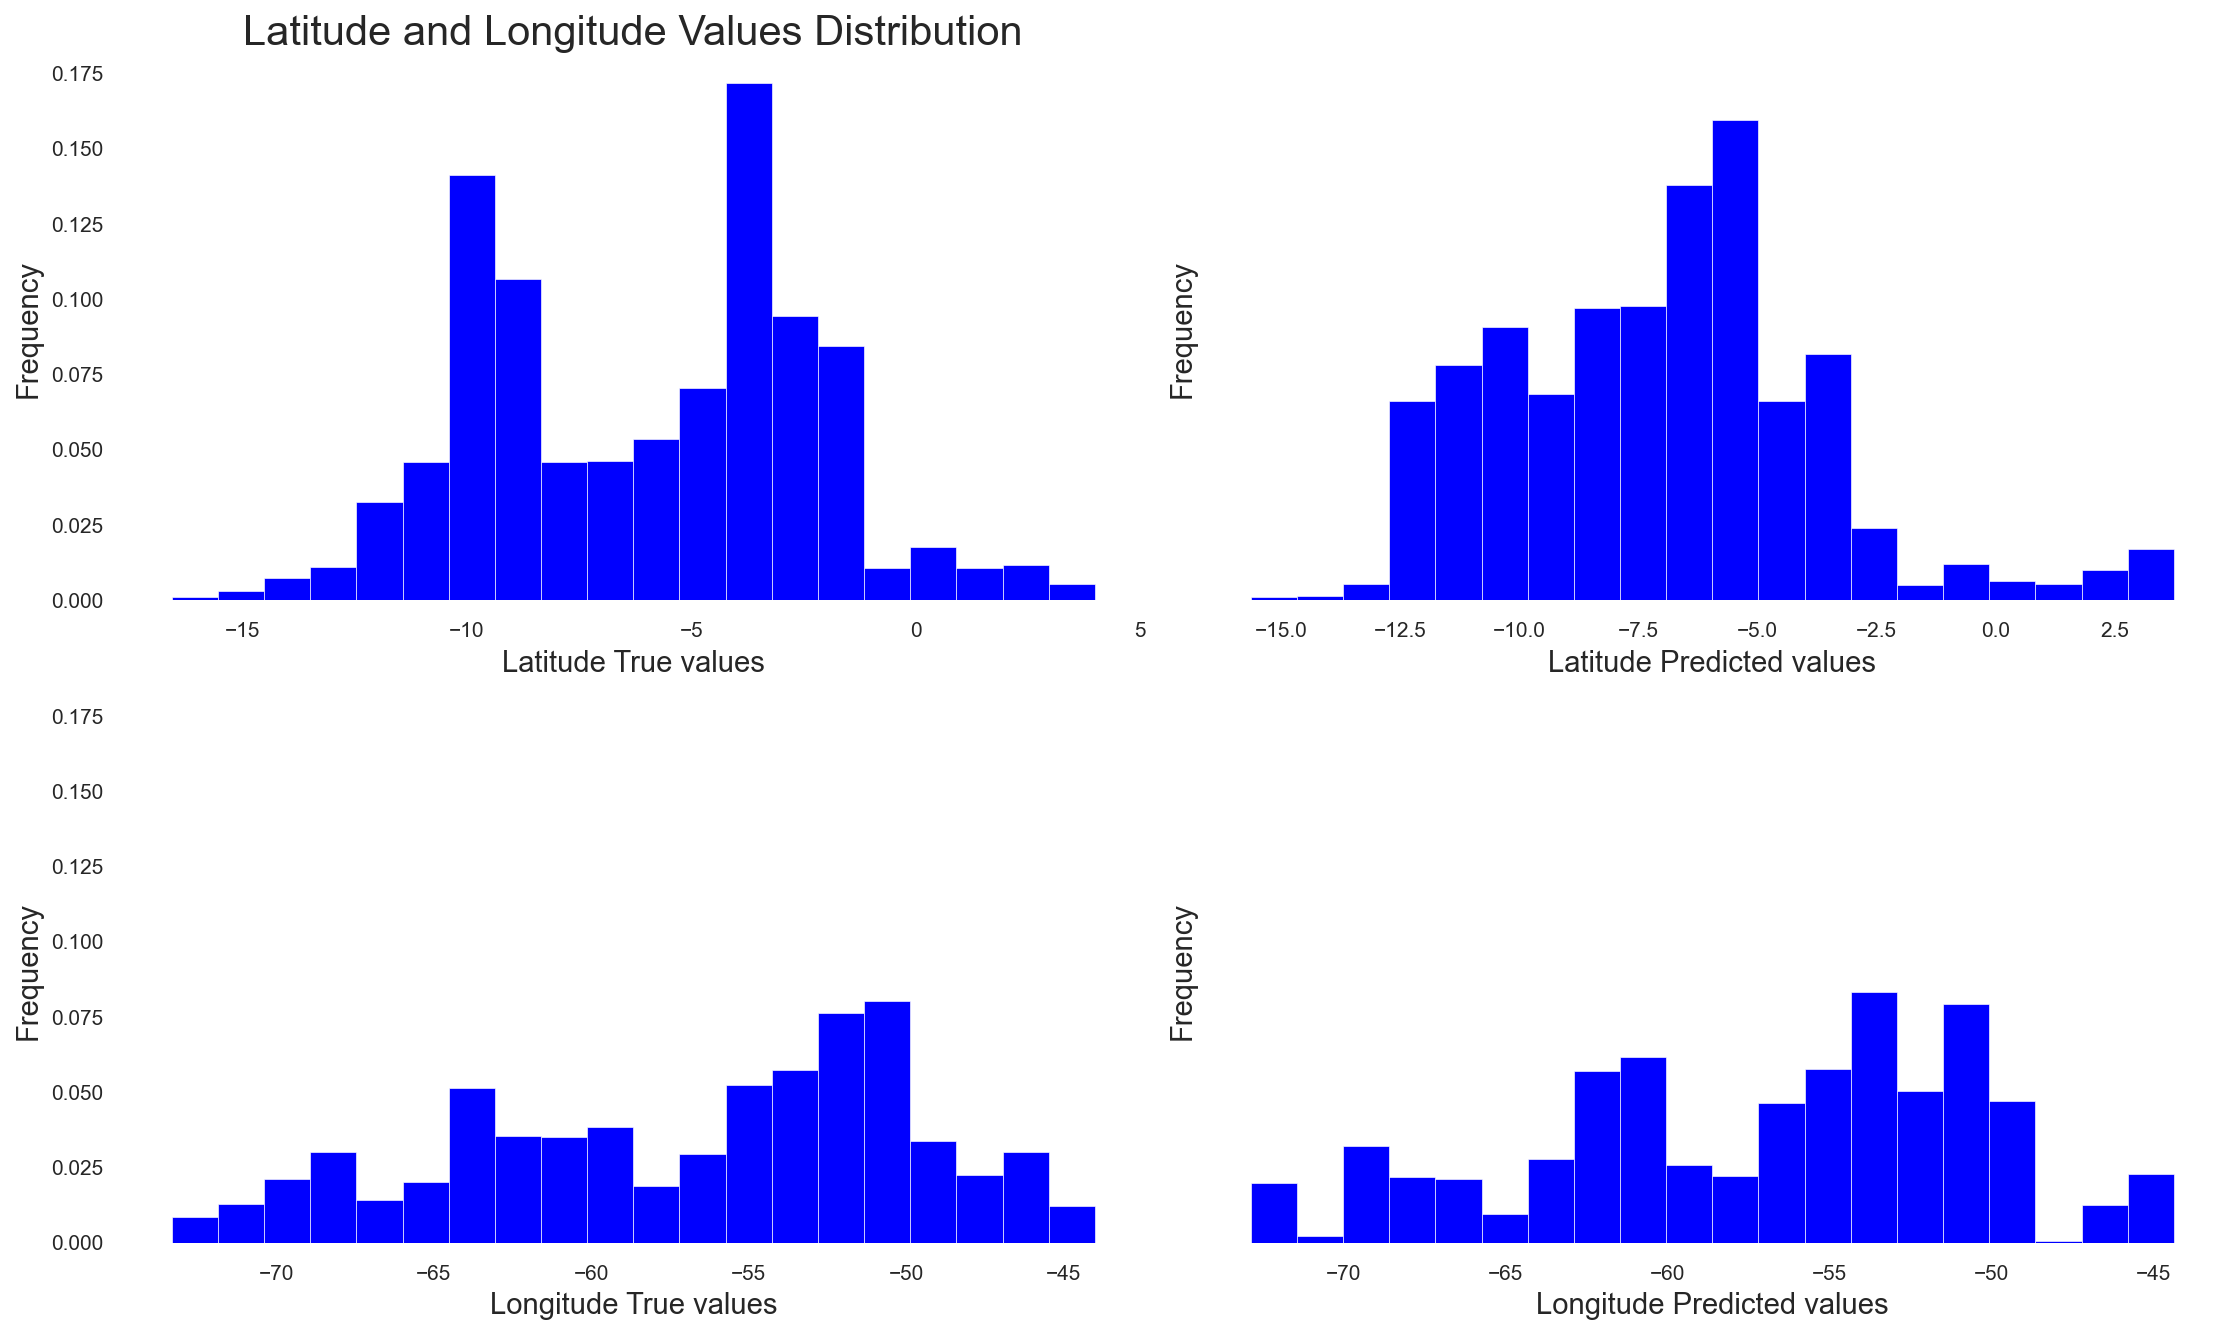

In [138]:
# true vs predicted values distribution xgboost
fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(15,9))

axs[0, 0].hist(y_test_1, bins=20, density=True, color='blue')
axs[0, 1].hist(y_pred_1, bins=20, density=True, color='blue');
axs[1, 0].hist(y_test_2, bins=20, density=True, color='blue')
axs[1, 1].hist(y_pred_2, bins=20, density=True, color='blue');

axs[0, 0].set_title('Latitude and Longitude Values Distribution', fontsize=20)
axs[0, 0].set_xlabel('Latitude True values', fontsize=14)
axs[0, 1].set_xlabel('Latitude Predicted values', fontsize=14)
axs[0, 0].set_ylabel('Frequency', fontsize=14)
axs[1, 0].set_ylabel('Frequency', fontsize=14)
axs[1, 0].set_xlabel('Longitude True values', fontsize=14)
axs[1, 1].set_xlabel('Longitude Predicted values', fontsize=14)
axs[0, 1].set_ylabel('Frequency', fontsize=14)
axs[1, 1].set_ylabel('Frequency', fontsize=14);

In [ ]:
# dump files for heroku app
import joblib
dump(xgb1, 'xgb1.joblib', compress=('lzma', 5))
dump(xgb2, 'xgb2.joblib', compress=('lzma', 5))

In [ ]:
# very heavy, can't use for heroku app
dump(rf1, 'rf1.joblib', compress=('lzma', 5))
dump(rf2, 'rf2.joblib', compress=('lzma', 5))

In [140]:
# define function with xgb model (xgboost peformed better for sample data) to use on heroku
def predict(areakm_squared, day, month, year, states):

    # Make dataframe from the inputs
    df = pd.DataFrame(
        data=[[areakm_squared, day, month, year, states]], 
        columns=['areakm_squared', 'day', 'month', 'year', 'states']
    )
    
    # Get the model's prediction
    pred1 = xgb1.predict(df)[0]
    pred2 = xgb2.predict(df)[0]

    print(pred1)
    print(pred2)

    results = f'Latitude {pred1}, Longitude {pred2}'
    return results

In [141]:
predict(0.03, 25, 3, 2017, 'Tocantis')

-6.50296
-51.796867


'Latitude -6.502960205078125, Longitude -51.79686737060547'